# Convolutions for Images

Now that we understand how convolutional layers work in theory,
we are ready to see how they work in practice.
Building on our motivation of convolutional neural networks
as efficient architectures for exploring structure in image data,
we stick with images as our running example.


In [17]:
import torch
from torch import nn
from d2l import torch as d2l
import matplotlib.pyplot as plt

## The Cross-Correlation Operation

Recall that strictly speaking, convolutional layers
are a  misnomer, since the operations they express
are more accurately described as cross-correlations.
Based on our descriptions of convolutional layers in :numref:`sec_why-conv`,
in such a layer, an input tensor
and a kernel tensor are combined
to produce an output tensor through a (**cross-correlation operation.**)

Let's ignore channels for now and see how this works
with two-dimensional data and hidden representations.
In :numref:`fig_correlation`,
the input is a two-dimensional tensor
with a height of 3 and width of 3.
We mark the shape of the tensor as $3 \times 3$ or ($3$, $3$).
The height and width of the kernel are both 2.
The shape of the *kernel window* (or *convolution window*)
is given by the height and width of the kernel
(here it is $2 \times 2$).

![Two-dimensional cross-correlation operation. The shaded portions are the first output element as well as the input and kernel tensor elements used for the output computation: $0\times0+1\times1+3\times2+4\times3=19$.](../img/correlation.svg)
:label:`fig_correlation`

In the two-dimensional cross-correlation operation,
we begin with the convolution window positioned
at the upper-left corner of the input tensor
and slide it across the input tensor,
both from left to right and top to bottom.
When the convolution window slides to a certain position,
the input subtensor contained in that window
and the kernel tensor are multiplied elementwise
and the resulting tensor is summed up
yielding a single scalar value.
This result gives the value of the output tensor
at the corresponding location.
Here, the output tensor has a height of 2 and width of 2
and the four elements are derived from
the two-dimensional cross-correlation operation:

$$
0\times0+1\times1+3\times2+4\times3=19,\\
1\times0+2\times1+4\times2+5\times3=25,\\
3\times0+4\times1+6\times2+7\times3=37,\\
4\times0+5\times1+7\times2+8\times3=43.
$$

Note that along each axis, the output size
is slightly smaller than the input size.
Because the kernel has width and height greater than $1$,
we can only properly compute the cross-correlation
for locations where the kernel fits wholly within the image,
the output size is given by the input size $n_\textrm{h} \times n_\textrm{w}$
minus the size of the convolution kernel $k_\textrm{h} \times k_\textrm{w}$
via

$$(n_\textrm{h}-k_\textrm{h}+1) \times (n_\textrm{w}-k_\textrm{w}+1).$$

This is the case since we need enough space
to "shift" the convolution kernel across the image.
Later we will see how to keep the size unchanged
by padding the image with zeros around its boundary
so that there is enough space to shift the kernel.
Next, we implement this process in the `corr2d` function,
which accepts an input tensor `X` and a kernel tensor `K`
and returns an output tensor `Y`.


In [2]:
def corr2d(X, K):  #@save
    """
    Compute 2D cross-correlation.

    The X is the input image and the K is the kernel.
    """
    h, w = K.shape
    # prefilling the output Y
    Y = torch.zeros((X.shape[0] - h + 1, X.shape[1] - w + 1))
    
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            Y[i, j] = (X[i:i + h, j:j + w] * K).sum()
    return Y

We can construct the input tensor `X` and the kernel tensor `K`
from :numref:`fig_correlation`
to [**validate the output of the above implementation**]
of the two-dimensional cross-correlation operation.


In [3]:
X = torch.tensor([[0.0, 1.0, 2.0],
                  [3.0, 4.0, 5.0],
                  [6.0, 7.0, 8.0]])
K = torch.tensor([[0.0, 1.0],
                  [2.0, 3.0]])
corr2d(X, K)

tensor([[19., 25.],
        [37., 43.]])

## Convolutional Layers

A convolutional layer cross-correlates the input and kernel
and adds a scalar bias to produce an output.
The two parameters of a convolutional layer
are the kernel and the scalar bias.
When training models based on convolutional layers,
we typically initialize the kernels randomly,
just as we would with a fully connected layer.

We are now ready to [**implement a two-dimensional convolutional layer**]
based on the `corr2d` function defined above.
In the `__init__` constructor method,
we declare `weight` and `bias` as the two model parameters.
The forward propagation method
calls the `corr2d` function and adds the bias.


In [120]:
class Conv2D(nn.Module):
    '''
    THIS IS OUR CLASS -- MANUAL
    '''
    def __init__(self, kernel_size):
        super().__init__()
        self.weight = nn.Parameter(torch.rand(kernel_size))
        self.bias = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        return corr2d(x, self.weight) + self.bias

In
$h \times w$ convolution
or an $h \times w$ convolution kernel,
the height and width of the convolution kernel are $h$ and $w$, respectively.
We also refer to
a convolutional layer with an $h \times w$
convolution kernel simply as an $h \times w$ convolutional layer.


## Object Edge Detection in Images

Let's take a moment to parse [**a simple application of a convolutional layer:
detecting the edge of an object in an image**]
by finding the location of the pixel change.
First, we construct an "image" of $6\times 8$ pixels.
The middle four columns are black ($0$) and the rest are white ($1$).


In [92]:
X = torch.ones((6, 8))
X[:, 2:6] = 0
X

tensor([[1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.]])

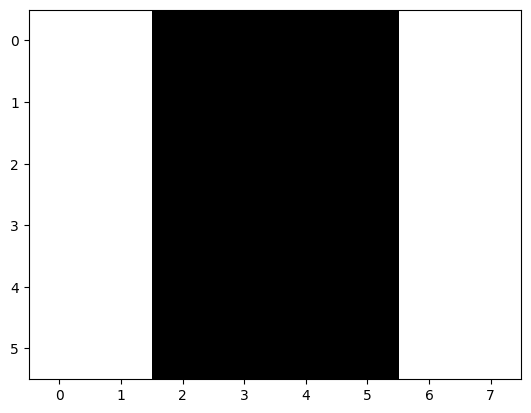

In [93]:
plt.imshow(X, cmap="gray");

> The current image has the **vertical** edges.

In [94]:
# this is the kernel which will detect **vertical edge**
K = torch.tensor([[1.0, -1.0]])

We are ready to perform the cross-correlation operation
with arguments `X` (our input) and `K` (our kernel).
As you can see, [**we detect $1$ for the edge from white to black
and $-1$ for the edge from black to white.**]
All other outputs take value $0$.


In [95]:
Y = corr2d(X, K)
Y

tensor([[ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.]])

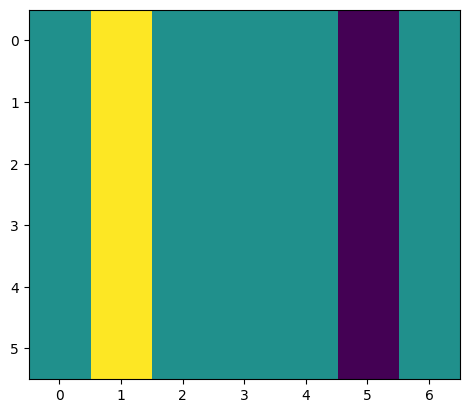

In [96]:
plt.imshow(Y)

We can now apply the kernel to the transposed image.
As expected, it vanishes. [**The kernel `K` only detects vertical edges.**]


In [97]:
# making the edges horizontal...
X.t()

tensor([[1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.]])

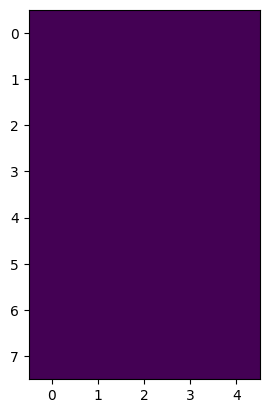

In [98]:
# the kernel is not detecting them!
Y = corr2d(X.t(), K)
plt.imshow(Y);

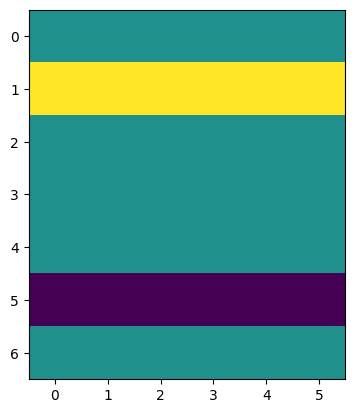

In [99]:
# making a horizontal detector
K = torch.tensor([[1.0],[-1.0]])
Y = corr2d(X.t(), K)
plt.imshow(Y);

> Daaang!

## Learning a Kernel

Designing an edge detector by finite differences `[1, -1]` is neat
if we know this is precisely what we are looking for.
However, as we look at larger kernels,
and consider successive layers of convolutions,
it might be impossible to specify
precisely what each filter should be doing manually.

Now let's see whether we can [**learn the kernel that generated `Y` from `X`**]
by looking at the input--output pairs only.
We first construct a convolutional layer
and initialize its kernel as a random tensor.
Next, in each iteration, we will use the squared error
to compare `Y` with the output of the convolutional layer.
We can then calculate the gradient to update the kernel.
For the sake of simplicity,
in the following
we use the built-in class
for two-dimensional convolutional layers
and ignore the bias.


### Resetting the values... so that we can learn the kernel

In [100]:
X.shape, Y.shape

(torch.Size([6, 8]), torch.Size([7, 6]))

In [137]:
X = torch.ones((6, 8))
X[:, 2:6] = 0
X

tensor([[1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.]])

In [138]:
K = torch.tensor([[1.0, -1.0]])
Y = corr2d(X, K)

# this is what we will use as a **true target**
Y

tensor([[ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.]])

In [102]:
# Construct a two-dimensional convolutional layer with 1 output channel and a
# kernel of shape (1, 2). For the sake of simplicity, we ignore the bias here
conv2d = nn.LazyConv2d(1, kernel_size=(1, 2), bias=False)

# The two-dimensional convolutional layer uses four-dimensional input and
# output in the format of (example, channel, height, width), where the batch
# size (number of examples in the batch) and the number of channels are both 1
X = X.reshape((1, 1, 6, 8))
Y = Y.reshape((1, 1, 6, 7))
lr = 3e-2  # Learning rate

for i in range(20):
    Y_hat = conv2d(X)
    l = (Y_hat - Y) ** 2
    conv2d.zero_grad()
    l.sum().backward()
    # Update the kernel
    conv2d.weight.data[:] -= lr * conv2d.weight.grad
    if (i + 1) % 2 == 0:
        print(f'epoch {i + 1}, loss {l.sum():.3f}')

epoch 2, loss 3.831
epoch 4, loss 0.763
epoch 6, loss 0.177
epoch 8, loss 0.050
epoch 10, loss 0.017
epoch 12, loss 0.006
epoch 14, loss 0.002
epoch 16, loss 0.001
epoch 18, loss 0.000
epoch 20, loss 0.000


Note that the error has dropped to a small value after 10 iterations. Now we will [**take a look at the kernel tensor we learned.**]


In [61]:
conv2d.weight.data.reshape((1, 2))

tensor([[ 1.0009, -0.9987]])

## Our CONV

In [139]:
X = torch.ones((6, 8))
X[:, 2:6] = 0
X

tensor([[1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.]])

In [140]:
K = torch.tensor([[1.0, -1.0]])
Y = corr2d(X, K)

# this is what we will use as a **true target**
Y

tensor([[ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.]])

In [143]:
%xmode Minimal

Exception reporting mode: Minimal


In [144]:
conv2d = Conv2D(kernel_size=(1, 2))

X = X.reshape((1, 1, 6, 8))
Y = Y.reshape((1, 1, 6, 7))
lr = 3e-2  # Learning rate

for i in range(20):
    Y_hat = conv2d(X)
    l = (Y_hat - Y) ** 2
    conv2d.zero_grad()
    l.sum().backward()
    # Update the kernel
    conv2d.weight.data[:] -= lr * conv2d.weight.grad
    if (i + 1) % 2 == 0:
        print(f'epoch {i + 1}, loss {l.sum():.3f}')

RuntimeError: The size of tensor a (0) must match the size of tensor b (7) at non-singleton dimension 3

^^^ This error is because we are trying to use the X which has the shape of 1, 1, 6, 8... while our self made version is **not supporting** such dimensions.

vvv To solve that we will **remove the reshaping** steps and just... it will work as it should.

In [146]:
X = torch.ones((6, 8))
X[:, 2:6] = 0
K = torch.tensor([[1.0, -1.0]])
Y = corr2d(X, K)

In [147]:
conv2d = Conv2D(kernel_size=(1, 2))

lr = 3e-2  # Learning rate

for i in range(20):
    Y_hat = conv2d(X)
    l = (Y_hat - Y) ** 2
    conv2d.zero_grad()
    l.sum().backward()
    # Update the kernel
    conv2d.weight.data[:] -= lr * conv2d.weight.grad
    if (i + 1) % 2 == 0:
        print(f'epoch {i + 1}, loss {l.sum():.3f}')

epoch 2, loss 6.121
epoch 4, loss 1.499
epoch 6, loss 0.445
epoch 8, loss 0.154
epoch 10, loss 0.058
epoch 12, loss 0.023
epoch 14, loss 0.009
epoch 16, loss 0.004
epoch 18, loss 0.002
epoch 20, loss 0.001


In [149]:
conv2d.weight

Parameter containing:
tensor([[ 1.0025, -0.9973]], requires_grad=True)

## Image with diagonal edge

In [71]:
X = torch.diag(torch.full((5,), 1))
X

tensor([[1, 0, 0, 0, 0],
        [0, 1, 0, 0, 0],
        [0, 0, 1, 0, 0],
        [0, 0, 0, 1, 0],
        [0, 0, 0, 0, 1]])

In [72]:
K

tensor([[ 1., -1.]])

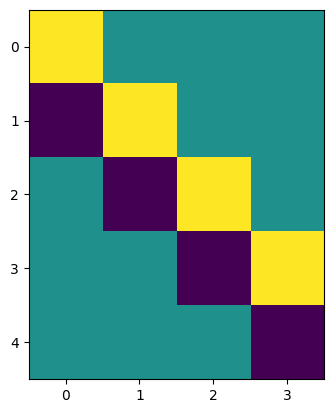

In [75]:
plt.imshow(corr2d(X, K))

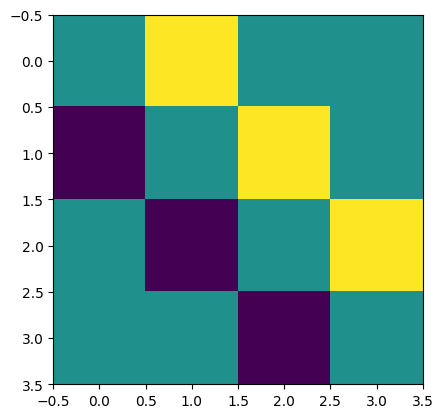

In [83]:
K = torch.tensor([[0, -1],
                   [1, 0]])
plt.imshow(corr2d(X, K))

[Discussions](https://discuss.d2l.ai/t/66)
